In [1]:
from my_functions import *

#Main Libraries 
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import datetime
import scipy.fftpack
import tensorflow as tf
from tensorflow import keras # And the tf and keras framework, thanks to Google
from tensorflow.python.framework import ops
import scipy.io as io
from io import BytesIO
import sys, os, time
import math
from scipy.fft import fft, fftfreq #Fourier
import pywt # Wavelet
from tqdm import tqdm # for print progress <---------------------------------------------------
import cv2 # computer vision problems library
from scipy.spatial import Delaunay # Delaunay triangulation <-- need it for Alpha Shape
from skimage.restoration import denoise_wavelet #Noise
import matplotlib.patheffects as PathEffects
import seaborn as sns
from sklearn.manifold import TSNE
import time
from IPython.display import Audio # <---- play audio

#Extra Libraries 
from mpl_toolkits import mplot3d
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
from matplotlib import cm
from scipy.spatial.distance import pdist, squareform
import random
import pandas as pd # data processing, CSV file I/O 
import seaborn as sns #I used sns.distplot because it has more manual properties than plt.hist()
from scipy.stats import pearsonr #includes the PCC function

#--------------------------------------------------------------------- Saved Compressed Sub Wavelet Data
compress_sub_img_o_1 = "Wavelet_Data/comp_sub_o_1.mat"
compress_sub_img_o_2 = "Wavelet_Data/comp_sub_o_2.mat"
compress_sub_img_o_3 = "Wavelet_Data/comp_sub_o_3.mat"
compress_sub_img_o_4 = "Wavelet_Data/comp_sub_o_4.mat"
compress_sub_img_o_5 = "Wavelet_Data/comp_sub_o_5.mat"
compress_sub_img_o_6 = "Wavelet_Data/comp_sub_o_6.mat"
compress_sub_img_o_7 = "Wavelet_Data/comp_sub_o_7.mat"
compress_sub_img_o_8 = "Wavelet_Data/comp_sub_o_8.mat"
#------------------------------
compress_sub_img_c_1 = "Wavelet_Data/comp_sub_c_1.mat"
compress_sub_img_c_2 = "Wavelet_Data/comp_sub_c_2.mat"
compress_sub_img_c_3 = "Wavelet_Data/comp_sub_c_3.mat"
compress_sub_img_c_4 = "Wavelet_Data/comp_sub_c_4.mat"
compress_sub_img_c_5 = "Wavelet_Data/comp_sub_c_5.mat"

#--------------------------------------------------------------------- Path to Save Wavelet_Frequences Data
frequences_o_1 = "Wavelet_Data/frequences_o_1.mat" 
frequences_o_2 = "Wavelet_Data/frequences_o_2.mat"
frequences_o_3 = "Wavelet_Data/frequences_o_3.mat" 
frequences_o_4 = "Wavelet_Data/frequences_o_4.mat"
frequences_o_5 = "Wavelet_Data/frequences_o_5.mat"
frequences_o_6 = "Wavelet_Data/frequences_o_6.mat" 
frequences_o_7 = "Wavelet_Data/frequences_o_7.mat"
frequences_o_8 = "Wavelet_Data/frequences_o_8.mat"  
#------------------------------
frequences_c_1 = "Wavelet_Data/frequences_c_1.mat" 
frequences_c_2 = "Wavelet_Data/frequences_c_2.mat"  
frequences_c_3 = "Wavelet_Data/frequences_c_3.mat"
frequences_c_4 = "Wavelet_Data/frequences_c_4.mat"
frequences_c_5 = "Wavelet_Data/frequences_c_5.mat"

In [2]:
wavelet_path = compress_sub_img_c_1
freqs_path = frequences_c_1

#---------------------------- Load Wavelet data
wavelet_trackdata = io.loadmat(wavelet_path)
wavelet_data = wavelet_trackdata['saved_data'];
print("Number of Bursts in Dataset:",wavelet_data.shape[0])
print("Number of Wavelets/Spikes per Burst:",wavelet_data.shape[1])
print("Total Number of Wavelets in Dataset:",wavelet_data.shape[0]*wavelet_data.shape[1])
print("Wavelet 2D-Image with shape:",wavelet_data.shape[2:])     
#---------------------------- Load Frequency data
freqs_trackdata = io.loadmat(freqs_path)
freqs_data = freqs_trackdata['saved_data'];
freqs_data = freqs_data[0]
print("Frequences shape:",freqs_data.shape)

Number of Bursts in Dataset: 106
Number of Wavelets/Spikes per Burst: 13
Total Number of Wavelets in Dataset: 1378
Wavelet 2D-Image with shape: (80, 200)
Frequences shape: (80,)


Alpha Shape:https://en.wikipedia.org/wiki/Alpha_shape

In [3]:
#---------------------------- This function takes a 2D-Array Image and the values that are lower than threshold it makes them Zero
def Keep_Values_Higher_Than_Threshold(arr,threshold):
    curr_arr = np.float32(np.array([row[:] for row in arr]))
    for i in range(0,curr_arr.shape[0]):
        for j in range(0,curr_arr.shape[1]):
            if(curr_arr[i,j]<threshold):
                curr_arr[i,j] = 0
    return(curr_arr)

#---------------------------- This function takes a 2D-Array Grid and returns the same array but in a form of plane 2D -->(2,n)
def Transform_Image_to_Points(img):
    img_points = []
    def column_extract(matrix, matrix_index):
        return [row[matrix_index] for row in matrix]
    for j in range(0,img.shape[1]):
        curr_column = column_extract(img, j)
        for i in range(0,len(curr_column)):
            if(curr_column[i]>0):
                img_points.append([j,i])
    img_points = np.array(img_points) 
    return(img_points)

# https://stackoverflow.com/questions/23073170/calculate-bounding-polygon-of-alpha-shape-from-the-delaunay-triangulation 
#---------------------------- Compute the alpha shape (concave hull) of a set of 2D (n,2) points.
def Alpha_Shape_Edges(points, alpha, only_outer=True): # param only_outer: boolean value to specify if we keep only the outer border or also inner edges. 
    #return: set of (i,j) pairs representing edges of the alpha-shape. (i,j) are the indices in the points array.                
    if points.shape[0] < 3: # "Need at least four points"
        return None  
    def add_edge(edges, i, j): # Add a line between the i-th and j-th points, if not in the list already
        if (i, j) in edges or (j, i) in edges:
            # already added
            assert (j, i) in edges, "Can't go twice over same directed edge right?"
            if only_outer: # if both neighboring triangles are in shape, it is not a boundary edge
                edges.remove((j, i))
            return
        edges.add((i, j))
    tri = Delaunay(points)
    edges = set()
    for ia, ib, ic in tri.simplices: # Loop over triangles: ia, ib, ic = indices of corner points of the triangle
        pa = points[ia]
        pb = points[ib]
        pc = points[ic]
        # Computing radius of triangle circumcircle --> www.mathalino.com/reviewer/derivation-of-formulas/derivation-of-formula-for-radius-of-circumcircle
        a = np.sqrt((pa[0] - pb[0]) ** 2 + (pa[1] - pb[1]) ** 2)
        b = np.sqrt((pb[0] - pc[0]) ** 2 + (pb[1] - pc[1]) ** 2)
        c = np.sqrt((pc[0] - pa[0]) ** 2 + (pc[1] - pa[1]) ** 2)
        s = (a + b + c) / 2.0
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        circum_r = a * b * c / (4.0 * area)
        if circum_r < alpha:
            add_edge(edges, ia, ib)
            add_edge(edges, ib, ic)
            add_edge(edges, ic, ia)
    return edges

#---------------------------- This functions takes a 2D image/array and returns layers of this image in alpha shape in color scale values: between 0-255 values (white is 255)
def Alpha_Shape_Layers(image,thresholds_list,dpi,alpha):
    fig = plt.figure(frameon=False) 
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    for threshold_item in thresholds_list:
        img_with_threshold = Keep_Values_Higher_Than_Threshold(image,threshold_item)
        img_transform = Transform_Image_to_Points(img_with_threshold)

        edges = Alpha_Shape_Edges(img_transform, alpha=alpha, only_outer=True) # Computing the alpha shape 
        if(not(edges==None)):
            for i, j in edges:
                ax.plot(img_transform[[i, j], 0], img_transform[[i, j], 1],color=str(1-threshold_item))
    plt.gca().invert_yaxis()
    plt.plot(0,0)
    plt.plot(image.shape[1]-1,image.shape[0]-1)

    # define a function which returns an image as numpy array from figure
    def get_img_from_fig(fig, dpi=180):
        buf = BytesIO()
        fig.savefig(buf, format="png", dpi=dpi)
        buf.seek(0)
        img_arr = np.frombuffer(buf.getvalue(), dtype=np.uint8)
        buf.close()
        img = cv2.imdecode(img_arr, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return img

    alpha_img_with_colors = get_img_from_fig(fig,dpi)
    #plt.show()
    plt.close()
    return(alpha_img_with_colors)

#---------------------------- This functions takes a 2D Alpha shape image/array and returns the alpha image of it scales it between [0,1] values with 0 no activity and 1 the highest activity
def Alpha_Shape_Scaling(alpha_img_with_colors,thresholds_list):
    thresholds_list_color_color = []
    for item in thresholds_list:
        thresholds_list_color_color.append((1-item)*255)
    thresholds_list_color_color = np.array(thresholds_list_color_color)
    alpha_img_scaled = np.zeros((alpha_img_with_colors.shape[0],alpha_img_with_colors.shape[1]))
    for i in range(0,alpha_img_with_colors.shape[0]):
        for j in range(0,alpha_img_with_colors.shape[1]):
            closest_color_index = min(range(len(thresholds_list_color_color)), key=lambda h: abs(thresholds_list_color_color[h]-alpha_img_with_colors[i,j]))
            alpha_img_scaled[i,j] = thresholds_list[closest_color_index]
    return(alpha_img_scaled)

#---------------------------- This functions this function takes an image/2d-array and returns its alpha shape form: a high relosution image and an image in the same size as initial image
def Alpha_Shape_Transformation(init_img,thresholds_list,dpi,alpha):
    alpha_img_with_colors = Alpha_Shape_Layers(init_img,thresholds_list,dpi,alpha) 
    #print(alpha_img_with_colors.shape) 
    alpha_img = Alpha_Shape_Scaling(alpha_img_with_colors,thresholds_list)
    alpha_img_init_size = Resize_Img(alpha_img,init_img.shape[0],init_img.shape[1])
    return(alpha_img,alpha_img_init_size)

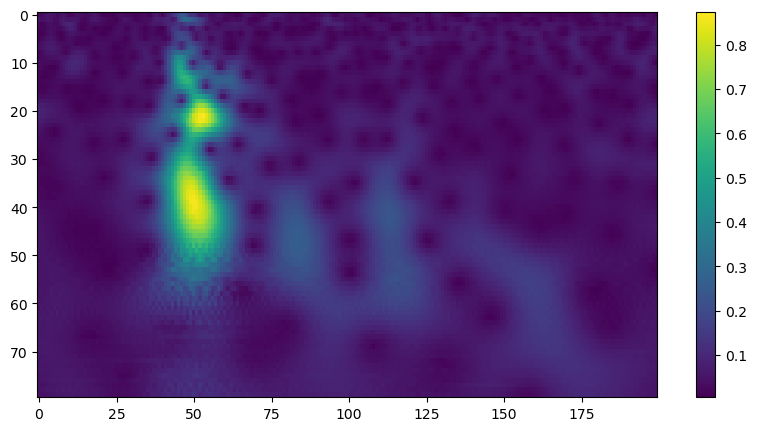

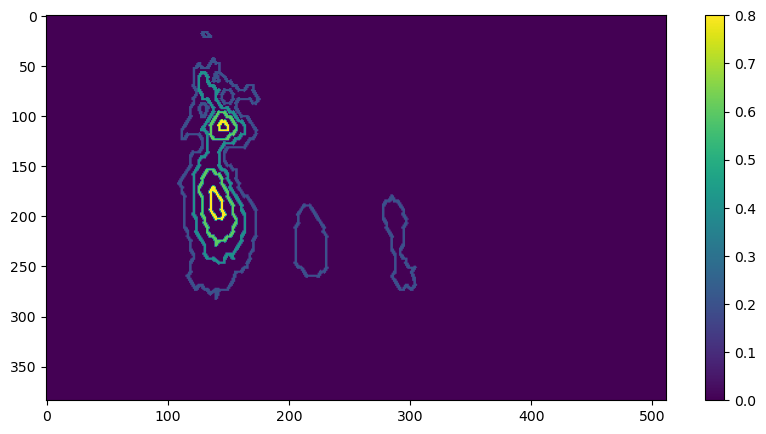

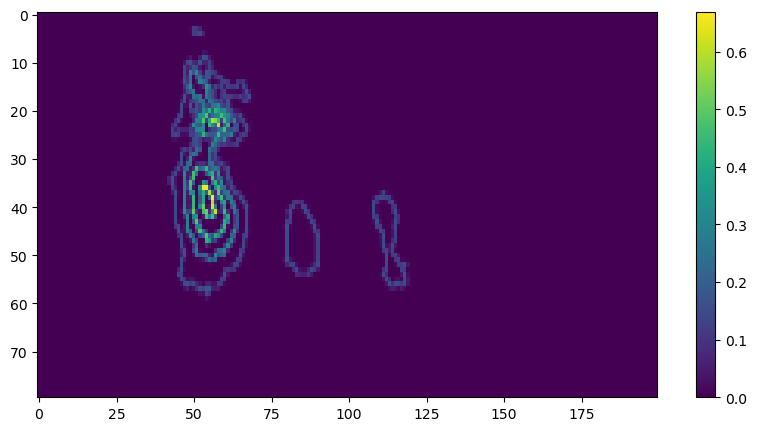

In [4]:
#----------------------- Plot for 1 wavelet and Alpha shape
wavelet = wavelet_data[50,5] 
wavelet_alpha, wavelet_alpha_resized = Alpha_Shape_Transformation(wavelet,[0,0.20,0.40,0.60,0.80,1], dpi=80, alpha=1.25)

plt.figure(1, figsize=(10,5))
plt.imshow(wavelet, aspect='auto')
plt.colorbar()
plt.show() 

plt.figure(1, figsize=(10,5))
plt.imshow(wavelet_alpha, aspect='auto')
plt.colorbar()
plt.show() 

plt.figure(1, figsize=(10,5))
plt.imshow(wavelet_alpha_resized, aspect='auto')
plt.colorbar()
plt.show() 

In [5]:
#----------------------- Save multiple alpha shapes
wavelet_frames_alpha = []
for i in (range(0,(wavelet_data.shape[0]))): 
    burst_wavelets_alpha = []
    for j in (range(0,(wavelet_data.shape[1]))): 
        print("----",i,j)
        wavelet = wavelet_data[i,j] 
        wavelet_alpha, wavelet_alpha_resized = Alpha_Shape_Transformation(wavelet,[0,0.20,0.40,0.60,0.80,1], dpi=80, alpha=1.25)
        burst_wavelets_alpha.append(wavelet_alpha)
    burst_wavelets_alpha = np.array(burst_wavelets_alpha)
    wavelet_frames_alpha.append(burst_wavelets_alpha)
wavelet_frames_alpha = np.array(wavelet_frames_alpha)
print(wavelet_frames_alpha.shape)

#--------------------------------------------------- Save CWT Data
io.savemat('Wavelet_Data_Alpha/c1', mdict={'saved_data': wavelet_frames_alpha})
print("SAVED Wavelets----------------------------------------")

---- 0 0
---- 0 1
---- 0 2
---- 0 3
---- 0 4
---- 0 5
---- 0 6
---- 0 7
---- 0 8
---- 0 9
---- 0 10
---- 0 11
---- 0 12
---- 1 0
---- 1 1
---- 1 2
---- 1 3
---- 1 4
---- 1 5
---- 1 6
---- 1 7
---- 1 8
---- 1 9
---- 1 10
---- 1 11
---- 1 12
---- 2 0
---- 2 1
---- 2 2
---- 2 3
---- 2 4
---- 2 5
---- 2 6
---- 2 7
---- 2 8
---- 2 9
---- 2 10
---- 2 11
---- 2 12
---- 3 0
---- 3 1
---- 3 2
---- 3 3
---- 3 4
---- 3 5
---- 3 6
---- 3 7
---- 3 8
---- 3 9
---- 3 10
---- 3 11
---- 3 12
---- 4 0
---- 4 1
---- 4 2
---- 4 3
---- 4 4
---- 4 5
---- 4 6
---- 4 7
---- 4 8
---- 4 9
---- 4 10
---- 4 11
---- 4 12
---- 5 0
---- 5 1
---- 5 2
---- 5 3
---- 5 4
---- 5 5
---- 5 6
---- 5 7
---- 5 8
---- 5 9
---- 5 10
---- 5 11
---- 5 12
---- 6 0
---- 6 1
---- 6 2
---- 6 3
---- 6 4
---- 6 5
---- 6 6
---- 6 7
---- 6 8
---- 6 9
---- 6 10
---- 6 11
---- 6 12
---- 7 0
---- 7 1
---- 7 2
---- 7 3
---- 7 4
---- 7 5
---- 7 6
---- 7 7
---- 7 8
---- 7 9
---- 7 10
---- 7 11
---- 7 12
---- 8 0
---- 8 1
---- 8 2
---- 8 3
----

QhullError: QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate   48

While executing:  | qhull d Qt Qc Q12 Qz Qbb
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1481658482  delaunay  Qtriangulate  Qcoplanar-keep  Q12-allow-wide
  Qz-infinity-point  Qbbound-last  _pre-merge  _zero-centrum  Qinterior-keep
  Pgood  _max-width  2  Error-roundoff 6.7e-14  _one-merge 4.7e-13
  Visible-distance 1.3e-13  U-max-coplanar 1.3e-13  Width-outside 2.7e-13
  _wide-facet 8e-13  _maxoutside 5.3e-13
